In [8]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, mean_absolute_error
torch.set_default_dtype(torch.float64)
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import psutil

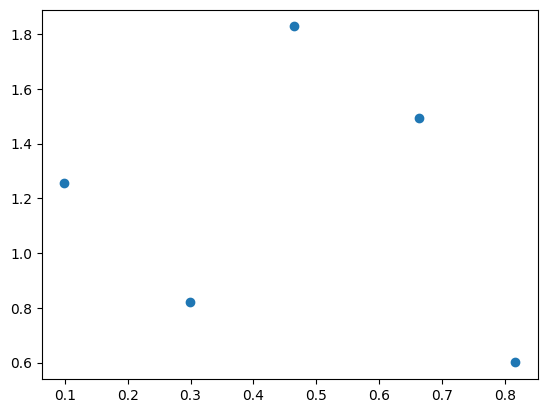

In [2]:
# Generating inital values for Wall slip parameters

#tau_w_range = [0.001, 1] 
#m_range = [0.5, 2]

lower= [0.001, 0.5]
upper = [1, 2]

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(5)

scaled_values = qmc.scale(sample, lower, upper)
tau_w_values = scaled_values[:,0]
m_values = scaled_values[:,1]
plt.scatter(tau_w_values, m_values)
plt.show()


In [3]:
def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    guess_disp_interpolated = np.interp(real_time, guess_time, guess_disp)
    diff_disp = np.abs(real_disp - guess_disp_interpolated)
    area = np.trapezoid(diff_disp, real_time)
    return area
            
file_directory = Path("H:\\XMLFiles")
real_data_directory = "H:\\Real_data\\press_displacement_real.xml"
areas = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data = []

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1]  




In [9]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"
area_data = []

Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
Project = Synergy.Project
Project.OpenItemByName("60SurfaceCoverage_study", "Study")

# Simulation loop for wall slip parameters
for i in range(5):
    tau_w = tau_w_values[i]
    m = m_values[i]
    print(f"Simulation {i+1} with tau_w : {tau_w} and m: {m}")

    study_name =f"study_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\study_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(10)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(10)

    Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"study_{i+1}", "Study")



    

    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    Plot = PlotMgr.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_{i + 1}.xml", "Metric")
    guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}.xml")
    guess_root = guess_tree.getroot()
    
    
        
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
            time_value = time_block.attrib.get('Value')
            dept_value = dept_block.find('DeptValues').text.strip()
            guess_data.append((time_value, dept_value))

        
    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  
    
    
    area = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(area)
    print(area_data)

    
# Write the output to a log file
    with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

Simulation 1 with tau_w : 0.29849909124884455 and m: 0.8225924389595891
[np.float64(61.361750174997866)]
Simulation 2 with tau_w : 0.46510990580026673 and m: 1.828381384132764
[np.float64(61.361750174997866), np.float64(61.36415017499787)]
Simulation 3 with tau_w : 0.09954038535750608 and m: 1.2576314362253909
[np.float64(61.361750174997866), np.float64(61.36415017499787), np.float64(61.36675017499787)]
Simulation 4 with tau_w : 0.8161304962641014 and m: 0.6001766242404099
[np.float64(61.361750174997866), np.float64(61.36415017499787), np.float64(61.36675017499787), np.float64(61.366050174997866)]
Simulation 5 with tau_w : 0.663583050791809 and m: 1.4944959780691356
[np.float64(61.361750174997866), np.float64(61.36415017499787), np.float64(61.36675017499787), np.float64(61.366050174997866), np.float64(61.36755017499787)]
